# Feature engineering

Создание новых признаков - трудоемкий процесс, который позволяет значительно повысить точность модели при правильном использовании методов создания новых признаков. Самое большое повышение точности обычно случается после того, как Data Science разработчик погружается в предметную область задачи, потому что это позволяет создавать новые признаки осмысленно.  
Несмотря на это, есть автоматические/полуавтоматические методы создания новых признаков, о которых мы поговорим ниже.  
Для исследования темы создания новых признаков воспользуемся датасетом `vis_data` и дополним его новой информацией:

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

vis_data = pd.read_csv("train.csv", 
                       encoding = 'ISO-8859-1', 
                       low_memory = False)
vis_data = vis_data.drop(['violation_zip_code', 'clean_up_cost'], axis=1)
latlons = pd.read_csv("latlons.csv")
vis_data = pd.concat([vis_data, latlons], axis=1)

## Ручное создание признаков

Ручное создание признаков требует погружения в предметную область задачи и не всегда гарантирует положительный результат.  
Часто данные приходят без пояснения и есть только сами табличные данные и, если повезет, названия признаков. Нам повезло. Посмотрим на данные и на названия признаков:

In [2]:
vis_data.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,3.0,S. WICKER,CHICAGO,IL,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,Detroit,MI,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"14512 sussex, Detroit MI",42.394657,-83.194265


In [3]:
vis_data.columns

Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'non_us_str_code', 'country', 'ticket_issued_date',
       'hearing_date', 'violation_code', 'violation_description',
       'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee',
       'discount_amount', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance', 'address', 'lat',
       'lon'],
      dtype='object')

Судя по названию переменных, это данные о нарушителях, которые должны платить штраф за какое-то правонарушение.  
Есть переменная compliance, которая принимает значения `0`, `1` и `None`. Так как описания нет, мы можем предположить, что 0 - нарушитель заплатил штраф, 1 - не заплатил. Что в данном контексте означает None понять трудно, возможно, это пропуски, которые следует просто выбросить.  
Кроме изначальных признаков нам также дали ширину и долготу. Также, есть признак `city`. Что можно сделать с таким набором признаков? Например, можно посмотреть расстояние от точки правонарушения до центра города, в котором произошло нарушение. Давайте сначала исследуем, какие города представлены в выборке:

In [4]:
# Можно посмотреть на value_counts, не ограничивая вывод, 
# чтобы увидеть, как много там разных значений
vis_data.city.value_counts()[:10]

DETROIT             136936
SOUTHFIELD           13436
Detroit              10496
detroit               4183
DEARBORN              3637
FARMINGTON HILLS      2329
OAK PARK              2216
WARREN                2000
DET                   1657
W. BLOOMFIELD         1635
Name: city, dtype: int64

Видно, что подавляюще большую часть значений составляет `DETROIT`. Также, чуть ниже видны `Detroit` и `detroit`.  
Название города с самым большим количеством нарушений записано по-разному в данных. Возможно, некоторые другие города тоже записаны в разном регистре.  

In [5]:
vis_data.city = vis_data.city.apply(lambda x: x.lower())

In [6]:
vis_data.city.value_counts()[:10]

detroit             151621
southfield           14760
dearborn              4017
farmington hills      2508
oak park              2432
warren                2150
det                   1928
livonia               1798
w. bloomfield         1795
redford               1718
Name: city, dtype: int64

Теперь мы более точно видим, что большинство преступлений (из представленных в выборке) совершается в Детройте.  
Возможно, информативным признаком будет расстояние от места правонарушения до центра Детройта.  
Теперь давайте найдем для каждого нарушения, для которого есть широта и долгота, его расстояние до центра Детройта со следующими координатами:
 - широта: 42.331429
 - долгота: -83.045753

In [7]:
from math import radians, sin, cos, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return c * earth_radius

vis_data['distance'] = vis_data.apply(lambda row: 
                                      haversine(lon1 = -83.045753, 
                                                lat1 = 42.331429,
                                                lon2 = row['lon'], 
                                                lat2 = row['lat']), 
                                      axis=1)

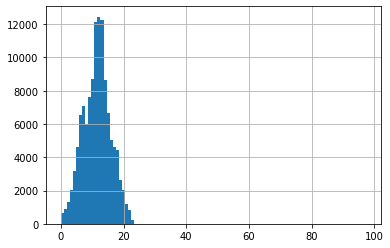

In [8]:
vis_data['distance'][vis_data['distance'] < 100].hist(bins=100);

## Создание полиномиальных признаков

Теперь рассмотрим более механические и менее интеллектуальные способы создать признаки. Новые признаки можно создавать, просто перемножением и делением старых признаков друг на друга.  
Кроме этого, можно брать один признак и возводить его, например, в квадрат или брать из него корень. То есть, в более общем виде, можно создать новый признак из старого, возведя все значения старого признака в дробную степень.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

Класс `PolynomialFeatures` из библиотеки `sklearn` принимает на вход набор признаков и на выходе отдает полиномиальные признаки, сгенерированные на основе входных и со степенью меньше либо равной указанной.  
Например, для признаков `[a, b]` и степени `2` он вернет `[1, a, b, a^2, ab, b^2]`.

In [10]:
pf = PolynomialFeatures(2)

In [11]:
poly_features = pf.fit_transform(vis_data[['balance_due', 'payment_amount']])
poly_features

array([[1.0000e+00, 3.0500e+02, 0.0000e+00, 9.3025e+04, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 7.5000e+01, 7.8000e+02, 5.6250e+03, 5.8500e+04,
        6.0840e+05],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [12]:
poly_features.shape

(250306, 6)

## Dummy-переменные

Когда мы говорим о категориальных признаках, есть два основных случая:
 - Категориальный признак содержит строки, никакая модель не примет их на вход, потребуется некоторое преобразование
 - Категориальный признак содержит числа. В таком случае, в принципе, можно никак не трогать этот признак, но это будет неправильно с точки зрения логики обучения модели.
 
Рассмотрим второй случай: есть признак "тип животного", который принимает `n` различных значений: значение 0, если животное - кошка, 1 - если тигр, 2 - если пантера. В отличие от `continuous` признаков, то есть, имеющих некоторый порядок, категориальные признаки такого порядка не имеют - мы не можем строго сравнить тигра и пантеру, это просто разные сущности. Некоторые алгоритмы могут работать с категориальными признаками, некоторые - нет.  
Естественной предобработкой для таких признаков является создание dummy-переменных на основе категориального признака, то есть, создание `n` признаков-индикаторов. Каждый из индикаторов равен 1 тогда, когда в изначальном примере выбрано соответствующее значение и 0 иначе. 
 

Преобразуем признак `state` в dummy-переменные и посмотрим его `shape`:

In [13]:
pd.get_dummies(vis_data.state).shape

(250306, 59)

Теперь преобразуем признак `city` в dummy-переменные. Для этого сначала требуется сделать небольшую предобработку, чтобы сократить количество уникальных значений в этом признаке. Для начала, найдем города, которые описывают большинство (`90%`) примеров:

In [14]:
cities_with_freqs = list(vis_data.city.value_counts())

In [15]:
top_cities_count = int(np.percentile(cities_with_freqs, 90))
top_cities_count

14

Теперь оставим только этот топ городов, остальные города назовем `other`:

In [16]:
all_cities = vis_data.city.value_counts().index
top_cities = list(all_cities)[:top_cities_count]
cities_to_throw_away = list(set(all_cities) - set(top_cities))
vis_data.loc[vis_data['city'].isin(cities_to_throw_away), 
             'city'] = 'other'

Теперь количество уникальных значений в признаке `city` сократилось до:

In [17]:
len(vis_data.city.value_counts())

15

Можем создать dummy-признаки для этой переменной:

In [18]:
pd.get_dummies(vis_data.city, drop_first=True).head()

,dearborn,det,detroit,eastpointe,farmington hills,livonia,oak park,other,redford,southfield,troy,w. bloomfield,warren,west bloomfield
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Работа с датой/временем

`Pandas` поддерживает работу с датами.  
[Больше про работу с временем в pandas](https://codeburst.io/dealing-with-datetimes-like-a-pro-in-pandas-b80d3d808a7f)  
Выберем признак, содержащий время, уберем пропуски и преобразуем его в специальный формат для работы со временем:

In [19]:
datetime_vals = pd.to_datetime(vis_data.payment_date.dropna())

In [20]:
datetime_vals.head()

1    2005-06-02
11   2005-03-17
15   2005-02-11
18   2005-03-18
19   2005-03-18
Name: payment_date, dtype: datetime64[ns]

Теперь к этим значениям можно обращаться для определения дня, месяца или года:

In [21]:
datetime_vals[1].month

6

Кроме этого, можно вытаскивать такие признаки, как день недели:

In [22]:
datetime_vals[1].weekday()

3

Отсчет начинается с понедельника и с нуля, поэтому мы понимаем, что это четверг.  
Почему это может быть важным признаком? Например, в текущем наборе данных можно использовать такой признак как будний день/выходной, чтобы определить, когда чаще совершают правонарушения:

In [23]:
dt_issued_date = pd.to_datetime(vis_data.ticket_issued_date)
vis_data['is_weekend'] = dt_issued_date.dt.weekday > 4
vis_data['wd'] = dt_issued_date.dt.weekday

Здесь мы воспользовались специальным селектором `dt`, который для удобства содержит методы для работы со временем в `pandas`.  

## Статистики по наборам признаков

Одним из интересных способов использовать данные для создания новых признаков является расчет различных статистик по данным.  
Примерами статистик могут быть минимум, максимум, стандартное отклонение и многие другие.  
Этот способ работает, если в данных содержится, помимо прочих признаков, некоторое подобие временных рядов.  
Например, примеры - это продукты, а зависимая переменная - купит ли покупатель этот продукт. Признаками, которые нас интересуют, будут стоимость данного продукта за 2015, 2016 и 2017 годы. В таком случае мы можем взять среднее, медиану, максимум, минимум и что угодно еще по этим трем столбцам и получить множество новых признаков.  
Не факт, что данные признаки будут полезны, это мы увидим на этапе валидации и тестирования. Но часто такие признаки действительно оказываются полезными.

In [ ]:
vis_data.co

In [ ]:
vis_data['eco']

In [ ]:
ecology_dict = {
    ''
}